In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import emcee
import corner
from IPython.display import display, Math
from lineticks import LineTicks
from scipy import integrate
from scipy.stats import norm

In [2]:
from IPython.core.display import HTML

# Center plots
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

We define some things for $\LaTeX$ here.
$
\def\D{\mathrm{d}}
\def\T{\mathsf{T}}
$

# The data

Let's read some data. First we read the data for each shot.

In [3]:
shots = pd.read_csv('shots.csv', index_col=0)
shots.tail()

,config_id,weight_in_basket,split_weight,split_brix
id,,,,
6,1,18.06,10.06,26.2
7,1,18.07,41.39,10.7
8,1,18.18,39.86,10.3
9,1,18.14,9.97,25.9
10,1,18.11,9.63,25.9


Each shot belongs to a configuration. The description for each configuration is located in a second file.

In [4]:
configs = pd.read_csv('configs.csv', index_col=0)
configs.tail()

,description
id,
1,"Hana Asrat Uraga (6.5 bar, no filter, grind 2...."


Now we calculate brew ratio, EY, and TDS for each shot.

In [5]:
shots['tds'] = shots['split_brix'] / 100. * 0.85
shots['ey'] = shots['tds'] * shots['split_weight'] / shots['weight_in_basket']
shots['brew_ratio'] = shots['split_weight'] / shots['weight_in_basket']
shots.tail()

,config_id,weight_in_basket,split_weight,split_brix,tds,ey,brew_ratio
id,,,,,,,
6,1,18.06,10.06,26.2,0.22270,0.124051,0.557032
7,1,18.07,41.39,10.7,0.09095,0.208324,2.290537
8,1,18.18,39.86,10.3,0.08755,0.191955,2.192519
9,1,18.14,9.97,25.9,0.22015,0.120998,0.549614
10,1,18.11,9.63,25.9,0.22015,0.117065,0.531750


# The model

We start with the following model of the extraction process:

$$
\text{EY} = M \left( 1 - \exp \left( -\frac{\text{BR}}{\tau} \right) \right)
$$

Here, $\text{EY}$ is the extraction yield, $M$ is the asymptotic extraction yield, $\text{BR}$ is the brew ratio, and $\tau$ is the time constant for extraction.

What does this look like?

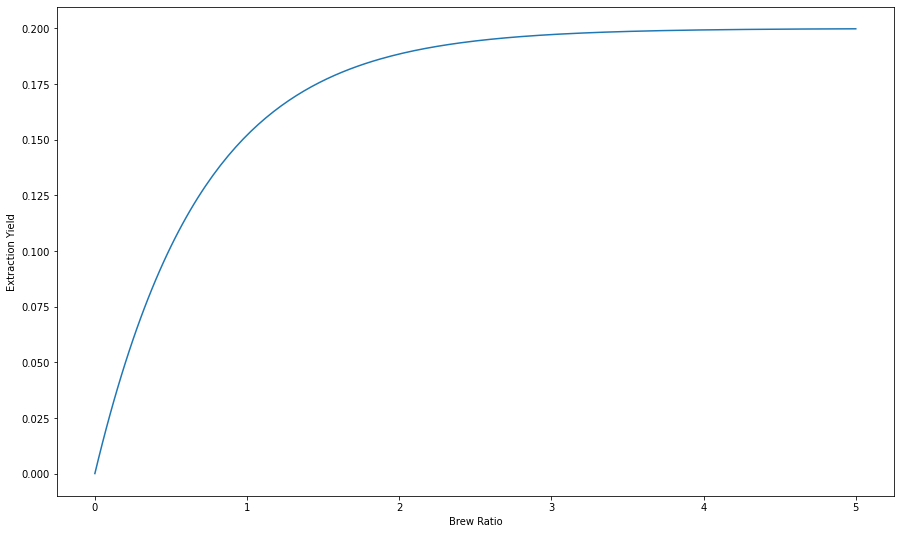

In [6]:
def model_ey(br, m, tau):
    return m * (1 - np.exp(-br / tau))

fig, ax = plt.subplots(figsize=(15,9))

ax.set_xlabel('Brew Ratio')
ax.set_ylabel('Extraction Yield')

xs = np.linspace(0., 5., 201)
ys = model_ey(xs, 0.2, 0.7)

ax.plot(xs, ys)

We don't measure brew ratio and extraction yield directly. Rather, we will be measuring the mass of dry coffee, $m_c$, the mass of the beverage, $m_b$, and the total dissolved solids, measured as degrees Brix, $\text{TDS}_{\text{Brix}}$. From these measurements, we calculate brew ratio and total dissolved solids, as a ratio, as follows:

$$
\text{BR} = \frac{m_b}{m_c}, \quad \text{TDS} = 0.85 \times \frac{\text{TDS}_{\text{Brix}}}{100}
$$

If we define the model in terms of brew ratio and extraction yield, as we did above, then we'll make our lives a little more difficult later on, because extraction yield depends on both mass and Brix measurements:

$$
\text{EY} = \text{BR} \times \text{TDS} = \frac{m_b}{m_c} \times 0.85 \times \frac{\text{TDS}_{\text{Brix}}}{100}
$$

This would make it more difficult to calculate the error associated with this model. Instead, we'll define the model in terms of brew ratio and TDS:

$$
\text{TDS} = \frac{M}{\text{BR}} \left( 1 - \exp \left( -\frac{\text{BR}}{\tau} \right) \right)
$$

This will make it a lot easier to calculate model error. Let's see what this looks like.

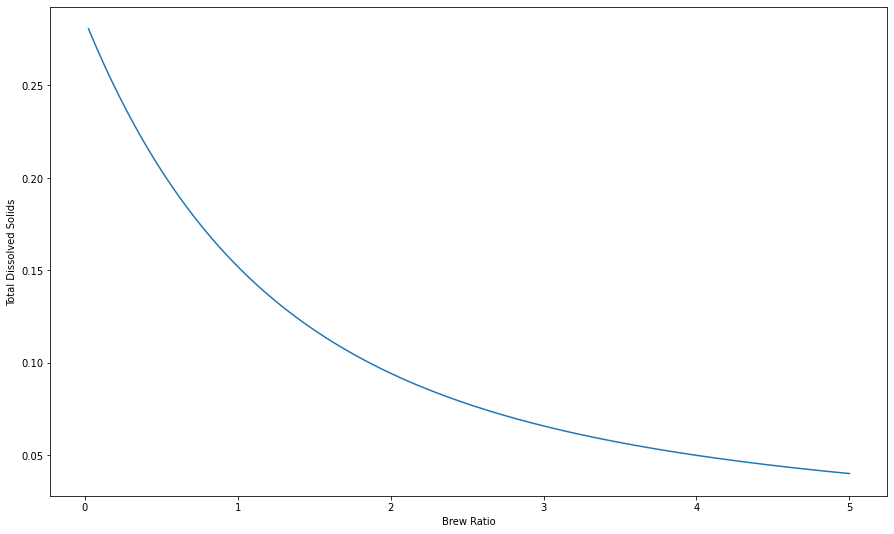

In [7]:
def model_tds(br, m, tau):
    return m / br * (1 - np.exp(-br / tau))

fig, ax = plt.subplots(figsize=(15,9))

ax.set_xlabel('Brew Ratio')
ax.set_ylabel('Total Dissolved Solids')

xs = np.linspace(0., 5., 201)[1:]
ys = model_tds(xs, 0.2, 0.7)

ax.plot(xs, ys)

# Measurement error

We assume our measurement errors are Guassian, with standard deviation $\sigma_m$ for mass measurements and $\sigma_{\text{Brix}}$ for Brix measurements. Now we want to propagate these measurement errors to our calculated values for $\text{BR}$ and $\text{TDS}$. First we calculate partial derivatives with respect to each measurement:

$$
\begin{gather}
\frac{\partial \, \text{BR}}{\partial m_b} = \frac{1}{m_c} \\
\frac{\partial \, \text{BR}}{\partial m_c} = -\frac{m_b}{m_c^2} \\
\frac{\partial \, \text{TDS}}{\partial \, \text{TDS}_\text{Brix}} = 0.0085 \\
\end{gather}
$$

Then:

$$
\begin{align}
\sigma_\text{BR}^2 &= \left( \frac{\partial \, \text{BR}}{\partial m_b} \sigma_m \right)^2 + \left( \frac{\partial \, \text{BR}}{\partial m_c} \sigma_m \right)^2 \\
&= \left( \frac{1}{m_c} \sigma_m \right)^2 + \left( -\frac{m_b}{m_c^2} \sigma_m \right)^2 \\
&= \frac{\sigma_m^2}{m_c^2} \left( 1 + \left( \frac{m_b}{m_c} \right)^2 \right) \\
\end{align}
$$

and

$$
\sigma_\text{TDS}^2 = \left( \frac{\partial \, \text{TDS}}{\partial \, \text{TDS}_\text{Brix}} \sigma_\text{Brix} \right)^2 = (0.0085 \times \sigma_\text{Brix})^2
$$

Let's calculate these measurement errors for each point in our data.

In [8]:
s_m = 0.05   # Error in weight measurements
s_brix = 0.2 # Error in Brix measurements

shots['s_tds'] = 0.0085 * s_brix
shots['s_br'] = s_m / shots['weight_in_basket'] * np.sqrt(1 + (shots['split_weight'] / shots['weight_in_basket'])**2)
shots.tail()

,config_id,weight_in_basket,split_weight,split_brix,tds,ey,brew_ratio,s_tds,s_br
id,,,,,,,,,
6,1,18.06,10.06,26.2,0.22270,0.124051,0.557032,0.0017,0.003169
7,1,18.07,41.39,10.7,0.09095,0.208324,2.290537,0.0017,0.006916
8,1,18.18,39.86,10.3,0.08755,0.191955,2.192519,0.0017,0.006628
9,1,18.14,9.97,25.9,0.22015,0.120998,0.549614,0.0017,0.003145
10,1,18.11,9.63,25.9,0.22015,0.117065,0.531750,0.0017,0.003127


# Maximum likelihood

There are two schools of thought on how to fit a model to experimental measurements: frequentism and Bayesianism. Jake VanderPlas has an excellent series of articles<sup>[1]</sup> discusing these two options. For this experiment, I'd like to try the Bayesian approach.

Given a single measurement $D_i = (\text{BR}_i, \text{TDS}_i)$ and a point $x = (\text{BR}_x, \text{TDS}_x)$, we can define the probability distribution for that measurement using the errors we just calculated:

$$
\begin{align}
P(D_i\,|\,x) &= \frac{1}{\sqrt{\det (2 \pi \Sigma)}} \exp \left( -\frac{1}{2} (D_i - x)^\T \Sigma^{-1} (D_i - x) \right) \\
&= \frac{1}{2 \pi \sigma_\text{BR} \sigma_\text{TDS}} \exp \left( -\frac{1}{2} \left( \frac{(\text{BR}_i - \text{BR}_x)^2}{\sigma_\text{BR}^2} + \frac{(\text{TDS}_i - \text{TDS}_x)^2}{\sigma_\text{TDS}^2} \right) \right)
\end{align}
$$

Further, given a set of model parameters $\theta$, we can integrate over our modelled curve to get the likelihood of the measurement $D_i$ given those model parameters:

$$
\begin{align}
\mathcal{L}(D_i\,|\,\theta) &= \int P(D_i\,|\,x(u, \theta))\,\D u\\
&= \int \frac{1}{2 \pi \sigma_\text{BR} \sigma_\text{TDS}} \exp \left( -\frac{1}{2} \left( \frac{(\text{BR}_i - \text{BR}(u, \theta))^2}{\sigma_\text{BR}^2} + \frac{(\text{TDS}_i - \text{TDS}(u, \theta))^2}{\sigma_\text{TDS}^2} \right) \right)\,\D u
\end{align}
$$

It doesn't look like we'll be able to get an analytic solution to this integral, so we'll need to integrate numerically. Let's define a function which returns the likelihood for a single measurement.

In [9]:
def single_probability(br_x, theta, br_i, tds_i, s_br_i, s_tds_i):
    m, tau = theta
    tds_x = model_tds(br_x, m, tau)
    return norm.pdf(br_x, br_i, s_br_i) * norm.pdf(tds_x, tds_i, s_tds_i)

def single_likelihood(theta, br_i, tds_i, s_br_i, s_tds_i):
    xs = np.linspace(0., 5., 2501)[1:]
    dx = xs[1] - xs[0]
    return sum(single_probability(xs, theta, br_i, tds_i, s_br_i, s_tds_i)) * dx

Let's do a sanity check at this point. The discrete integral above should return approximately the same result as numpy's integral.

In [10]:
theta = (0.2, 0.7)
br_i = 1.0
tds_i = 0.16
s_br_i = 0.1
s_tds_i = 0.1

print('Calling single_likelihood')
%time res = single_likelihood(theta, br_i, tds_i, s_br_i, s_tds_i)
print(f'-> {res}\n')

print('Calling integrate.quad')
%time res = integrate.quad(single_probability, 0, np.inf, \
                           args=(theta, br_i, tds_i, s_br_i, s_tds_i))[0]
print(f'-> {res}')

Calling single_likelihood
Wall time: 4 ms
-> 3.9640429383561684

Calling integrate.quad
Wall time: 75 ms
-> 3.9640429383561684


The two results are nearly the same, and the discrete integral is much faster.

Let's see what the probability density function looks like with actual data.

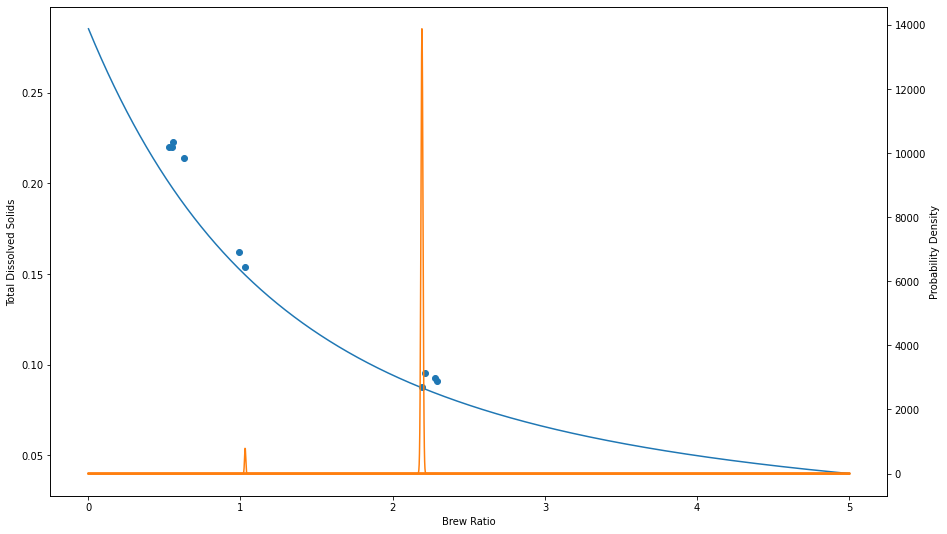

In [11]:
# Looking at just the first configuration
some_shots = shots[shots['config_id'] == 1]

fig, ax1 = plt.subplots(figsize=(15,9))
ax2 = ax1.twinx()

ax1.set_xlabel('Brew Ratio')
ax1.set_ylabel('Total Dissolved Solids')
ax2.set_ylabel('Probability Density')

# Plot best model curve
m, tau = theta
xs = np.linspace(0., 5., 2501)[1:]
ys = model_tds(xs, m, tau)

ax1.plot(xs, ys)

# Plot data points
br = np.array(some_shots['brew_ratio'])
tds = np.array(some_shots['tds'])
s_br = np.array(some_shots['s_br'])
s_tds = np.array(some_shots['s_tds'])

ax1.scatter(br, tds)

# Plot probability densities
for br_i, tds_i, s_br_i, s_tds_i in zip(br, tds, s_br, s_tds):
    ps = single_probability(xs, theta, br_i, tds_i, s_br_i, s_tds_i)
    ax2.plot(xs, ps, c='C1')

To get the likelihood for a set of measurements, we multiply the likelihoods for the individual measurements. Equivalently, we can get the log-likelihood for the set of measurements by adding up the log-likelihoods of the individual measurements:

In [12]:
def log_likelihood(theta, br, tds, s_br, s_tds):
    likelihoods = [single_likelihood(theta, br_i, tds_i, s_br_i, s_tds_i) 
                   for br_i, tds_i, s_br_i, s_tds_i in zip(br, tds, s_br, s_tds)]
    if np.all(np.array(likelihoods) > 0):
        return sum(np.log(likelihoods))
    else:
        return -np.inf

We can maximize likelihood to find the best fit curve for each configuration.

In [13]:
nll = lambda *args: -log_likelihood(*args)

# Optimize each configuration
for index, row in configs.iterrows():
    print(row['description'] + '...')

    some_shots = shots[shots['config_id'] == index]

    br = np.array(some_shots['brew_ratio'])
    tds = np.array(some_shots['tds'])
    s_br = np.array(some_shots['s_br'])
    s_tds = np.array(some_shots['s_tds'])
    
    initial = np.array([1., 1.])
    bounds = [(0., None), (0., None)]

    # We need to ease into the optimization
    for r in np.logspace(2., 0., num=3):
        soln = minimize(nll, initial, args=(br, tds, r * s_br, r * s_tds), bounds=bounds)
        initial = soln.x
    
    configs.at[index, 'fit_m'] = soln.x[0]
    configs.at[index, 'fit_tau'] = soln.x[1]

configs

Hana Asrat Uraga (6.5 bar, no filter, grind 2.20, 2 tamps)...


c:\python39\lib\site-packages\scipy\optimize\_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


,description,fit_m,fit_tau
id,,,
1,"Hana Asrat Uraga (6.5 bar, no filter, grind 2....",0.207739,0.630416


Now we can plot the maximum likelihood curve along with the data for each configuration. Although we calculate maximum likelihood in terms of TDS vs. brew ratio, we can transform the curve, e.g., to draw it in a plot of TDS vs. EY:

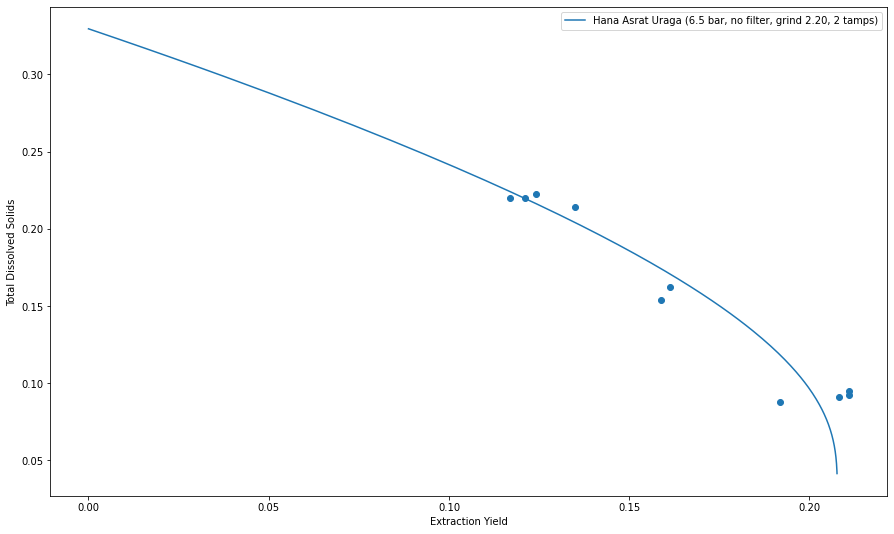

In [14]:
def plot_fit(ax, row, color=None, draw_ticks=False):
    m = row['fit_m']
    tau = row['fit_tau']
    
    fit_br = np.append([1e-6], np.linspace(0., 5., 201)[1:])
    fit_tds = model_tds(fit_br, m, tau)
    fit_ey = fit_br * fit_tds
    
    # Draw maximum likelihood curve
    traj, = ax.plot(fit_ey, fit_tds, color=color, label=row['description'])    

    if draw_ticks:
        # Draw ticks to indicate brew ratio
        major_ticks = LineTicks(traj, range(0, 201, 40), 10, lw=1, 
                                label=['{:.0f}'.format(round(tt)) for tt in fit_br[::40]])
        minor_ticks = LineTicks(traj, range(0, 201, 4), 4, lw=1)

def plot_points(ax, some_shots, color=None):
    br = np.array(some_shots['brew_ratio'])
    tds = np.array(some_shots['tds'])
    ey = br * tds
    
    # Draw data points
    ax.scatter(ey, tds, color=color)

fig, ax = plt.subplots(figsize=(15,9))

ax.set_xlabel('Extraction Yield')
ax.set_ylabel('Total Dissolved Solids')

for ci, (index, row) in enumerate(configs.iterrows()):
    some_shots = shots[shots['config_id'] == index]
    
    # Get plot colour
    color = f'C{ci}'

    # Plot maximum likelihood fit
    plot_fit(ax, row, color)

    # Plot points
    plot_points(ax, some_shots, color)

# We will use these values later
plt_xlim = ax.get_xlim()
plt_ylim = ax.get_ylim()
    
ax.legend()

# Markov chain Monte Carlo

At this point we've determined a best fit for each configuration, but we haven't estimated the accuracy of these results. To do this, we'll be using something called Markov chain Monte Carlo analysis. Jake VanderPlas's article includes sample code using a Python package called emcee<sup>[2]</sup>, and we will largely follow in his footsteps here.

The first thing we need to do is to define the prior probability distribution, also called simply "the prior". The prior encodes what we know about the model parameters before we make any experimental measurements. This can include the limits of each parameter, as well as the symmetry of each parameter--for example, if the parameter should be invariant under changes of scale or orientation.

For the time being, we'll use what's called a "flat" prior. A flat prior is easy to implement, but not necessarily "uninformative"--that is, it encodes some assumptions about the model parameters. It's worth reading the concerns about this prior in Jake's articles. Because the data has relatively tight error bars, I think the information contained in our likelihood will probably dominate the information in the prior anyway.

In [15]:
def log_prior(theta):
    m, tau = theta
    if m > 0 and tau > 0:
        return 0.
    else:
        return -np.inf

Now we define the posterior distribution, which is just the product of the prior and the likelihood we defined above.

In [16]:
def log_posterior(theta, br, tds, s_br, s_tds):
    lp = log_prior(theta)
    ll = log_likelihood(theta, br, tds, s_br, s_tds)
    if np.isfinite(lp) and np.isfinite(ll) :
        return lp + ll
    else:
        return -np.inf

Now we set up the computation:

In [17]:
ndim = 2  # number of parameters in the model
nwalkers = 50  # number of MCMC walkers
nburn = 100  # "burn-in" period to let chains stabilize
nthin = 15 # thin by about half the autocorrelation time
nsteps = 2000  # number of MCMC steps to take

Then we sample the distribution using emcee:

In [18]:
samplers = {}

for index, row in configs.iterrows():
    print(row['description'] + '...')
    
    some_shots = shots[shots['config_id'] == index]

    m = row['fit_m']
    tau = row['fit_tau']

    starting_guesses = [m, tau] + 1e-4 * np.random.randn(nwalkers, ndim)

    br = np.array(some_shots['brew_ratio'])
    tds = np.array(some_shots['tds'])
    s_br = np.array(some_shots['s_br'])
    s_tds = np.array(some_shots['s_tds'])

    samplers[index] = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, args=[br, tds, s_br, s_tds])
    samplers[index].run_mcmc(starting_guesses, nsteps, progress=True);

Hana Asrat Uraga (6.5 bar, no filter, grind 2.20, 2 tamps)...


100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [26:37<00:00,  1.25it/s]


The first thing we should take a look at is the autocorrelation time. Essentially, the autocorrelation time measures how independent our samples are--this is about how long it takes for the chain to "forget" a past state. We will get an error if the autocorrelation time is greater than 1/50 the number of samples.

In [19]:
for index, s in samplers.items():
    row = configs.loc[index]
    print(row['description'] + ':')
    print('    ' + str(s.get_autocorr_time()))

Hana Asrat Uraga (6.5 bar, no filter, grind 2.20, 2 tamps):
    [27.70733784 27.56706918]


Another useful diagnostic is the "corner plot". This shows the distribution of fit parameters within the generated samples, as well as the cross-correlation between the parameters.

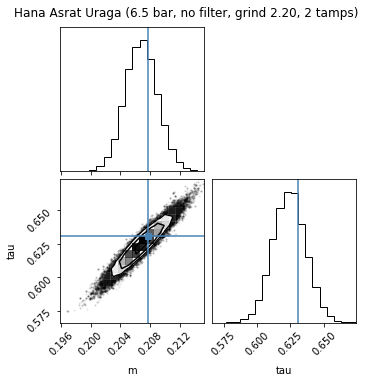

In [20]:
labels = ['m', 'tau']

for index, row in configs.iterrows():
    sampler = samplers[index]
    flat_samples = sampler.get_chain(flat=True)

    m = row['fit_m']
    tau = row['fit_tau']
    
    fig = corner.corner(
        flat_samples, labels=labels, truths=[m, tau]
    )
    
    fig.suptitle(row['description'])

This is about what we expect--roughly Gaussian distributions for $M$ and $\tau$, and a positive correlation between the two, i.e., when we increase $M$, $\tau$ also increases to get the best fit to the data.

We can report the fit parameters along with uncertainties based on the 16th and 84th percentiles as follows:

In [21]:
for index, s in samplers.items():
    row = configs.loc[index]
    print(row['description'] + ':')

    flat_samples = s.get_chain(flat=True)

    for i in range(ndim):
        mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
        q = np.diff(mcmc)
        txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"
        txt = txt.format(mcmc[1], q[0], q[1], labels[i])
        display(Math(txt))

Hana Asrat Uraga (6.5 bar, no filter, grind 2.20, 2 tamps):


<IPython.core.display.Math object>

<IPython.core.display.Math object>

Finally, we can use the generated samples to measure the 95% credible interval for our fit parameters as follows:

1. We use $M$ and $\tau$ from each of the generated samples to calculate TDS for several brew ratios.
2. For each brew ratio, we calculate the standard deviation of the calculated TDS values.
3. We generate upper and lower bounds for TDS using two standard deviations (95% credible interval).
4. Finally, we transform this region to our TDS vs. EY plot and display it as a filled area.

Here's what it looks like:

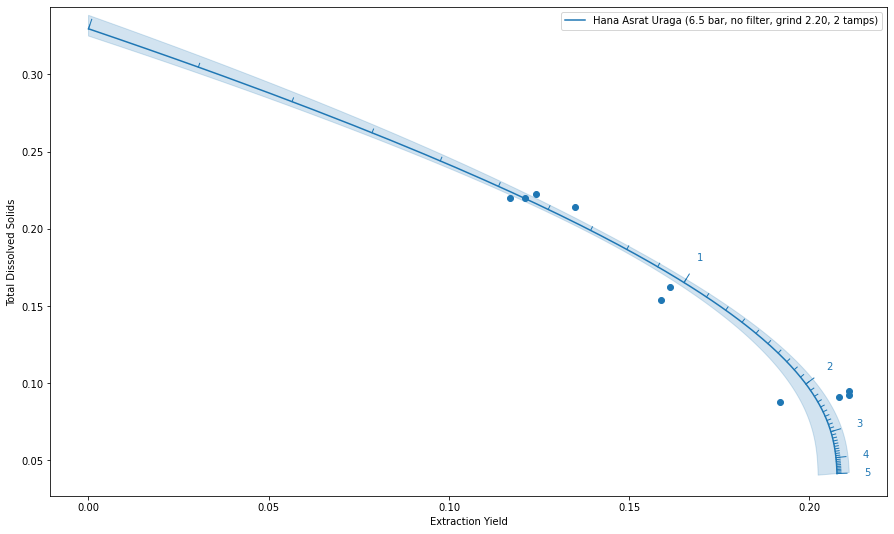

In [22]:
def plot_credible_interval(ax, sampler, color=None):
    emcee_m, emcee_tau = sampler.get_chain(discard=nburn, thin=nthin, flat=True).T

    emcee_br = np.append([1e-6], np.linspace(0., 5., 201)[1:])
    emcee_tds = model_tds(emcee_br, emcee_m[:, None], emcee_tau[:, None])
    
    mu = emcee_tds.mean(0)
    sig = 2 * emcee_tds.std(0)

    tds_upper = mu + sig
    tds_lower = mu - sig

    ey_upper = emcee_br * tds_upper
    ey_lower = emcee_br * tds_lower

    # Plot 95% credible interval
    plt.fill(np.append(ey_upper, ey_lower[::-1]), 
             np.append(tds_upper, tds_lower[::-1]), color=color, alpha=0.2)

fig, ax = plt.subplots(figsize=(15,9))

ax.set_xlabel('Extraction Yield')
ax.set_ylabel('Total Dissolved Solids')

plt.xlim(plt_xlim)
plt.ylim(plt_ylim)

for ci, (index, row) in enumerate(configs.iterrows()):
    some_shots = shots[shots['config_id'] == index]
    
    # Get plot colour
    color = f'C{ci}'

    # Plot maximum likelihood fit
    plot_fit(ax, row, color, draw_ticks=True)

    # Plot points
    plot_points(ax, some_shots, color)
    
    # Plot 95% credible interval
    plot_credible_interval(ax, samplers[index], color)

ax.legend()

# Process error

So why do so many points fall outside of the 95% credible interval?

The model I've used here accounts for measurement uncertainty, but it doesn't account for variation in the process itself. I think the most likely sources of process variation are:

* Variation in particle size distribution for the ground coffee
* Variation in pressure due to hysteresis in the over pressure valve in my Gaggia Classic Pro
* Variation in puck preparation

A complete model should account for these variations as well, but my first attempts at adding process error to the model have had issues with convergence. Typically, the maximum likelihood optimization will converge, but MCMC sampling will not.

# References

[1] http://jakevdp.github.io/blog/2014/03/11/frequentism-and-bayesianism-a-practical-intro/ \
[2] https://emcee.readthedocs.io/en/stable/